# Earthworks: Terrain Synthesis

Brendan Harmon  
2025-06-30

<figure>
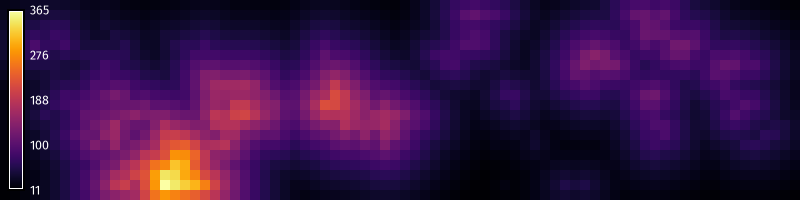
<figcaption aria-hidden="true">Volumetric change during terrain
synthesis</figcaption>
</figure>

Learn how to synthesize terrain with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html).
In terrain synthesis, landforms from one terrain are applied to another,
creating a hybrid landscape. This technique is used in computer graphics
to model landscapes that are challenging to create with procedural noise
and erosion simulations ([Zhou et
al. 2007](https://doi.org/10.1109/TVCG.2007.1027), [Tasse et
al. 2012](https://doi.org/10.1111/j.1467-8659.2012.03076.x), [Gain et
al. 2015](https://doi.org/10.1111/cgf.12545)). Landforms that are hard
to model, for example, can be sampled from real terrain and grafted onto
synthetic terrain. In this tutorial, we will use fractal terrain for
simplicity’s sake. Our process will be to:

-   Setup our environment
-   Generate a fractal terrain
-   Generate a fractal texture
-   Classify landforms in the texture map
-   Extract textures for select landforms
-   Shift clumps of texture to the same base elevation
-   Synthesize the terrain and extracted textures

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: center;"><div width="100.0%"
data-layout-align="center">
<table style="width:99%;">
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<thead>
<tr>
<th>Terrain</th>
<th>Texture</th>
<th>Synthesis</th>
</tr>
</thead>
<tbody>
<tr>
<td>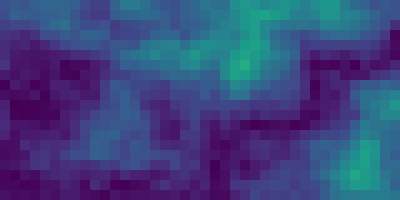</td>
<td>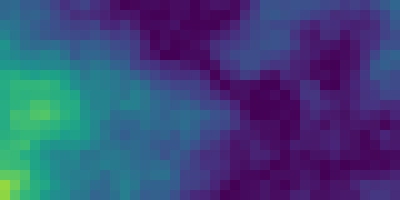</td>
<td>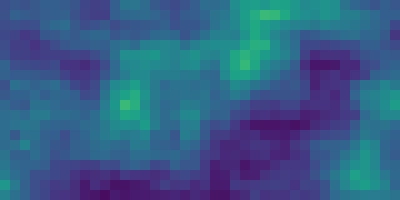</td>
</tr>
</tbody>
</table>
</div></td>
</tr>
</tbody>
</table>

Table 1: Terrain Synthesis

> **Computational notebook**
>
> This tutorial can be run as a [computational
> notebook](https://grass-tutorials.osgeo.org/content/tutorials/earthworks/synthesis.ipynb).
> Learn how to work with notebooks with the tutorial [Get started with
> GRASS & Python in Jupyter
> Notebooks](./get_started/fast_track_grass_and_python.qmd).

# Setup

## Project

Start a GRASS session in a new project with a Cartesian (XY) coordinate
system.

In [1]:
# Import libraries
import os
import sys
import subprocess
from pathlib import Path

# Find GRASS Python packages
sys.path.append(
  subprocess.check_output(
    ["grass", "--config", "python_path"],
    text=True
    ).strip()
  )

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Create a temporary folder
import tempfile
temporary = tempfile.TemporaryDirectory()

# Create a project in the temporary directory
gs.create_project(path=temporary.name, name="xy")

# Start GRASS in this project
session = gj.init(Path(temporary.name, "xy"))

## Installation

Install
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
with
[g.extension](https://grass.osgeo.org/grass-stable/manuals/g.extension.html).

In [2]:
# Install extension
gs.run_command("g.extension", extension="r.earthworks")

## Region

Use
[g.region](https://grass.osgeo.org/grass-stable/manuals/g.region.html)
to set the extent and resolution of the computational region. Create a
region starting at the origin and extending two hundred units north and
eight hundred units east. Set the resolution to ten.

In [3]:
# Set region
gs.run_command("g.region", n=200, e=800, s=0, w=0, res=10)

# Fractals

## Terrain

Generate a fractal terrain with
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html).
For reproducible results, set the `seed` to one. Then use the raster
calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to take the absolute value of the fractal and divide by a vertical scale
factor. Taking the absolute value of the fractal terrain will raise
cells with negative elevation values, turning low points into high
points and transforming slopes near zero into valleys.

In [4]:
# Generate fractal surface
gs.run_command(
    "r.surf.fractal",
    output="fractal",
    dimension=2.25,
    seed=1
    )
gs.mapcalc("fractal = abs(fractal) / 10")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="fractal")
m.d_legend(raster="fractal", at=(5, 95, 1, 3))
m.show()

<figure>
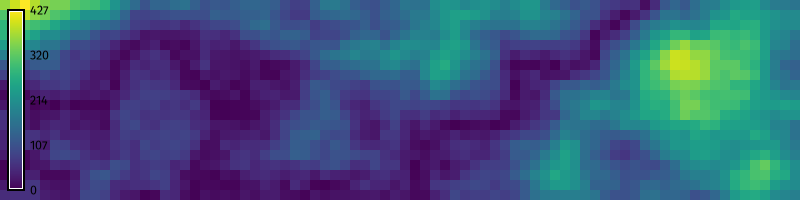
<figcaption aria-hidden="true">Fractal terrain</figcaption>
</figure>

## Texture

Repeat this process to generate a fractal texture that will be grafted
onto the original terrain. Set a different `seed` for
[r.surf.fractal](https://grass.osgeo.org/grass-stable/manuals/r.surf.fractal.html)
to generate a new fractal raster. If you wish to work with real rather
than synthetic elevation data, simply substitute these fractal rasters
with digital elevation models for real landscapes.

In [5]:
# Generate fractal surface
gs.run_command(
    "r.surf.fractal",
    output="texture",
    dimension=2.25,
    seed=3
    )
gs.mapcalc("texture = abs(texture) / 10")

# Visualize
m = gj.Map(width=800)
m.d_rast(map="texture")
m.d_legend(raster="texture", at=(5, 95, 1, 3))
m.show()

<figure>
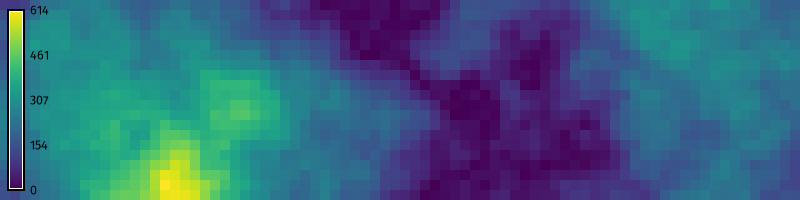
<figcaption aria-hidden="true">Fractal texture</figcaption>
</figure>

# Landforms

Classify the landforms in the fractal texture map with
[r.geomorphon](https://grass.osgeo.org/grass-stable/manuals/r.geomorphon.html).
Experiment with the `search` and `skip` parameters to classify different
scales of landforms.

In [6]:
# Classify landforms
gs.run_command(
    "r.geomorphon",
    elevation="texture",
    forms="forms",
    search=9
    )

# Visualize
m.d_rast(map="forms", flags="n")
m.d_legend(raster="forms", at=(5, 95, 1, 3))
m.show()

<figure>
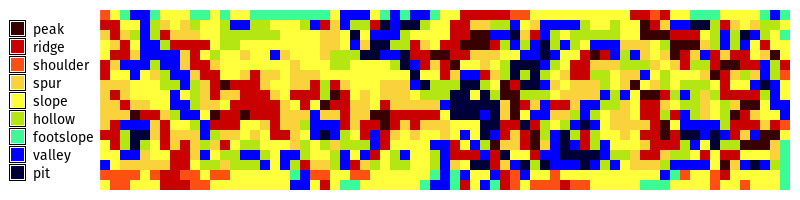
<figcaption aria-hidden="true">Landforms</figcaption>
</figure>

# Extraction

Extract textures for the peaks, ridges, shoulders, and spurs with the
raster calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html).
Write the map algebra expression
`ridges = if(forms > 1 && forms < 6, texture, null())`. All cells with
landforms classes greater than one and less than six will be assigned
elevation values from the texture map, while all others will be assigned
null values.

In [7]:
# Extract ridge texture
gs.mapcalc("ridges = if(forms > 1 && forms < 6, texture, null())")

# Visualize
m.d_rast(map="ridges", flags="n")
m.d_legend(raster="ridges", at=(5, 95, 1, 3))
m.show()

<figure>
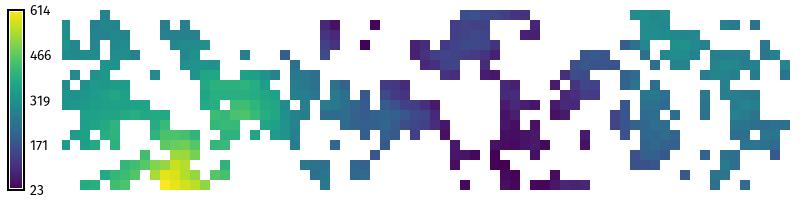
<figcaption aria-hidden="true">Ridge elevation</figcaption>
</figure>

# Shift

The map of extracted textures has elevation values that are relative to
vertical datum such as mean sea level. Because we will be grafting these
textures onto another terrain, we will reset the base elevation for each
clump of texture to zero. Find clumps of texture with
[r.clump](https://grass.osgeo.org/grass-stable/manuals/r.clump.html).
Then use
[r.stats.zonal](https://grass.osgeo.org/grass-stable/manuals/r.stats.zonal.html)
to find the minimum value - the base elevation - for each clump. Use the
raster calculator
[r.mapcalc](https://grass.osgeo.org/grass-stable/manuals/r.mapcalc.html)
to subtract the minimum value for each clump in the map of extracted
textures. This will set the lowest elevation for each clump to zero, so
that all clumps share the same base elevation.

In [8]:
# Find clumps
gs.run_command(
    "r.clump",
    input="ridges",
    output="clumps",
    threshold=0.5
    )

# Calculate zonal statistics
gs.run_command(
    "r.stats.zonal",
    base="clumps",
    cover="ridges",
    method="min",
    output="minimum"
    )

# Subtract base elevation
gs.mapcalc("ridges = ridges - minimum")

# Visualize
m.d_rast(map="ridges", flags="n")
m.d_legend(raster="ridges", at=(5, 95, 1, 3))
m.show()

<figure>
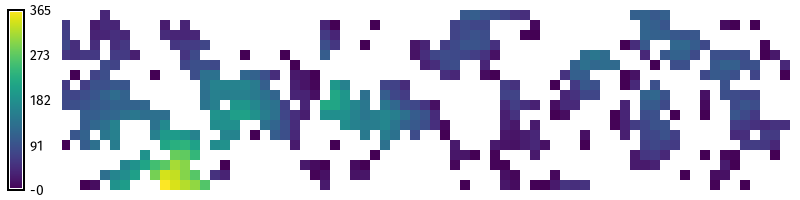
<figcaption aria-hidden="true">Shifted elevation</figcaption>
</figure>

# Synthesis

Synthesize the terrain and texture with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html).
Model a fill operation with the extracted textures relative to the
fractal terrain. Try setting an exponential rate of decay such as
`exponential=0.025`. Add a `volume` output to visualize the volumetric change.

In [9]:
# Synthesize ridges
gs.run_command(
    "r.earthworks",
    elevation="fractal",
    earthworks="synthesis",
    volume="volume",
    mode="relative",
    operation="fill",
    function="exponential",
    raster="ridges",
    exponential=0.025
    )

# Visualize
m.d_rast(map="synthesis")
m.d_legend(raster="synthesis", at=(5, 95, 1, 3))
m.show()

# Visualize
gs.run_command("r.colors", map="volume", color="inferno")
m.d_rast(map="volume")
m.d_legend(raster="volume", color="white", at=(5, 95, 1, 3))
m.show()

<figure>
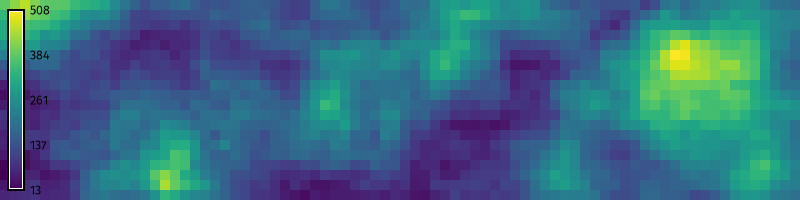
<figcaption aria-hidden="true">Terrain synthesis</figcaption>
</figure>

<figure>
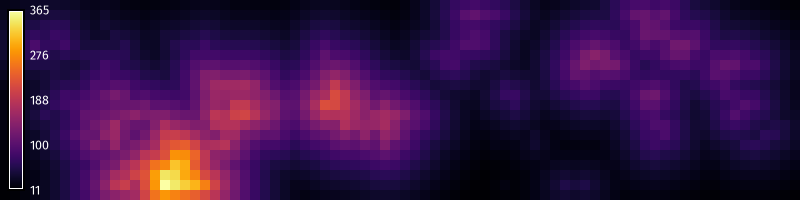
<figcaption aria-hidden="true">Volumetric change</figcaption>
</figure>